In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline

from itertools import accumulate

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, \
    f1_score, make_scorer, PrecisionRecallDisplay, RocCurveDisplay

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, \
    RandomOverSampler as ROS
from imblearn.under_sampling import RandomUnderSampler as RUS, \
    CondensedNearestNeighbour as CNN, TomekLinks, \
    EditedNearestNeighbours as ENN

from scipy.spatial.distance import pdist, squareform

import sys
import joblib
import six
import sklearn.ensemble._base
sys.modules['sklearn.externals.joblib'] = joblib
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.six.moves'] = six.moves
sys.modules['sklearn.ensemble.base'] = sklearn.ensemble._base
from costcla.models import CostSensitiveDecisionTreeClassifier as CSDTC
from costcla.metrics import savings_score

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_confusion_mtx(cm: 'confusion matrix', labels = None, 
                       figsize = (3,3), binary = True):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16}, 
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    if labels is None:
        labels = range(1, cm.shape[1] + 1)     
    ax.set_xticks(ax.get_xticks(), labels)
    ax.set_yticks(ax.get_yticks(), labels)
    if binary:
        ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

In [4]:
# Credits to prof. R. Guidotti

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [5]:
def plot_gains_curve(y_true:'np array', y_pred_proba:'np array', 
                     label = None, baseline = False):
    idx = np.argsort(y_pred_proba)[::-1]
    acc = list(accumulate(y_true[idx]))
    plt.plot(acc, label = label)
    n_samples = len(acc)
    if baseline:
        plt.plot([0,n_samples], [0, acc[-1]], 'k--')
    
    xticks = np.linspace(0, n_samples, 6)
    yticks = np.linspace(0, acc[-1], 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1) 
    y_lab = np.around(np.linspace(0, 1, 6), decimals = 1) 
    plt.xticks(xticks, x_lab)
    plt.yticks(yticks, y_lab)
    plt.xlabel('% of samples', fontsize = 14)
    plt.ylabel('Gain', fontsize = 14)

In [6]:
def plot_lift(y_true:'np array', y_pred_proba:'np array', 
              label = None, baseline = False):
    n_samples = len(y_true)
    idx = np.argsort(y_pred_proba)[::-1]
    cum_trues = list(accumulate(y_true[idx]))
    perc_trues = map(lambda x: x / cum_trues[-1], cum_trues)   
    cum_samples = range(1, n_samples + 1)
    perc_samples = map(lambda x: x / n_samples, cum_samples)  
    lift = list(map(lambda x, y: x / y, perc_trues, perc_samples))    
    plt.plot(lift, label = label)
    if baseline:
        plt.axhline(y = 1, ls = '--', color = 'k')
    plt.xlabel('% of samples', fontsize = 14)
    plt.ylabel('Lift', fontsize = 14)

In [7]:
def plot_decision_boundaries(X, classes, clf, 
                             class_names: dict = None, figsize = (6, 4)):
    '''
    classes: array-like containing numerical classes
    clf: the trained classifier
    class_names: dict mapping class numbers to class names    
    '''
    
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()    
    x_min, y_min = X.min(axis = 0) - 1
    x_max, y_max = X.max(axis = 0) + 1
    '''
    artificial generated points evenly spaced within the region 
    delimitated by our data. x_grid and y_grid are matrices 
    containing x and y coordinates respectively.
    '''
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 1000), 
                                 np.linspace(y_min, y_max, 1000))   
    # put together x and y coordinates to build a matrix of (x,y) points
    xy_coordinates = np.vstack((x_grid.ravel(), y_grid.ravel())).T  
    # predictions of the artificial points
    pred = clf.predict(xy_coordinates) # 1d array with size=100_000  
    # Plot decision boundary and scatter plot
    contourf = ax.contourf(x_grid, y_grid, pred.reshape(1000, 1000), alpha = 0.6)    
    scatter = ax.scatter(X[:, 0], X[:, 1], c = classes, edgecolor = 'k')
    handles, labels = scatter.legend_elements()
    if class_names is not None:
        # each item in labels has the format '$\\mathdefault{number}$'
        keys = [int(''.join(filter(str.isdigit, string))) for string in labels] 
        labels = [class_names[i] for i in keys]
    ax.legend(handles, labels, loc = 'lower center', ncol = 2, 
              fontsize = 'small', bbox_to_anchor = (0, 1, 1, 1)) 
    ax.set_xlabel('1st Component', fontsize = 14)
    ax.set_ylabel('2nd Component', fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])

## Data Preparation

In [8]:
# dataset with the 23 best variables selected during the feature analysis

X_train = pd.read_csv("best_X_train.csv", header = 0)
X_test = pd.read_csv("best_X_test.csv", header = 0)
y_train = pd.read_csv("y_train_wo_outliers_num.csv", header = None)[0]
y_test = pd.read_fwf("y_test.txt", header = None)[0]

In [9]:
X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep = '\n')

(7274, 23)
(2947, 23)
(7274,)
(2947,)


In [11]:
with open("features.txt") as f:
    lines = f.read().splitlines() 

features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name
    
# features

In [12]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

In [13]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [14]:
y_train_mapped = y_train.map(activities)

## Imbalance the dataset

Since point 1.4 of the project guidelines impose to perform a BINARY classification, there are only two alternatives:

- 1) relabel the activities in movement and stationary activities end perform binary classification.
- 2) select two classes, unbalance one of them, and perform a binary classification;

but:
- 3) We can also try to perform a multiclass classification by unbalancing one or more classes.

### 1)

In [15]:
# train set: movement and stationary activities 

mov_idx = y_train[y_train < 4].index
sta_idx = y_train[y_train > 3].index
y1_train = y_train.copy()

In [16]:
y1_train.loc[mov_idx] = 'Movement'
y1_train.loc[sta_idx] = 'Stationary'

In [17]:
# test set: movement and stationary activities
act_map = dict(zip(activities, ['Movement']*3 + ['Stationary']*3))
y1_test = y_test.map(act_map)
y1_test

0       Stationary
1       Stationary
2       Stationary
3       Stationary
4       Stationary
           ...    
2942      Movement
2943      Movement
2944      Movement
2945      Movement
2946      Movement
Name: 0, Length: 2947, dtype: object

In [18]:
np.unique(y1_train, return_counts = True)

(array(['Movement', 'Stationary'], dtype=object),
 array([3246, 4028], dtype=int64))

Let's try to unbalance the Movement class. Fixed the cardinality of stationary activities, in order to obtain an unbalanced configuration of 96-4% we have to solve: $\dfrac{x}{4067+x} = 0.04,\; x > 0$. That is, $x = 169.458$.

In [19]:
generator = np.random.default_rng(seed = 5)

In [20]:
mov_sample_idx = generator.choice(mov_idx, 169, replace = False)

In [21]:
new_idx = np.sort(np.hstack((mov_sample_idx, sta_idx)))
X1_train = X_train.loc[new_idx]
y1_train = y1_train.loc[new_idx]

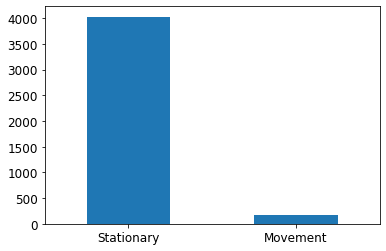

In [22]:
y1_train.value_counts().plot.bar(rot = 0)
plt.show()

In [23]:
clf = DTC().fit(X1_train, y1_train)
y_pred = clf.predict(X_test)

In [24]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [25]:
clf.get_depth()

1

In [26]:
clf.get_n_leaves()

2

In [27]:
print(classification_report(y1_test, y_pred))

              precision    recall  f1-score   support

    Movement       1.00      1.00      1.00      1387
  Stationary       1.00      1.00      1.00      1560

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947



There is no need to apply any classification imbalanced techniques because Movement and Stationary are well separated activities.

### 2)

Let's try to perform a binary classification between WALKING UPSTAIRS and WALKING DOWNSTAIRS

In [28]:
# let's select WALKING UPSTAIRS and WALKING DOWNSTAIRS in the train set

mask = (y_train == 2) | (y_train == 3)
idx = y_train[mask].index
X2_train = X_train.loc[idx]
y2_train = y_train.loc[idx]

X2_train.shape, y2_train.shape

((2021, 23), (2021,))

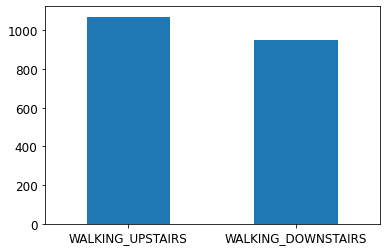

In [29]:
y2_train.value_counts().plot.bar(rot = 0)
ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks(xticks, ['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
plt.show()

In [30]:
np.unique(y2_train, return_counts = True)

(array([2, 3], dtype=int64), array([1070,  951], dtype=int64))

The two classes are balanced

In [31]:
# let's select WALKING UPSTAIRS and WALKING DOWNSTAIRS in the test set

mask = (y_test == 2) | (y_test == 3)
idx = y_test[mask].index
X2_test = X_test.loc[idx]
y2_test = y_test.loc[idx]

X2_test.shape, y2_test.shape

((891, 23), (891,))

In [32]:
clf = DTC(random_state = 5).fit(X2_train, y2_train)
y_pred = clf.predict(X2_test)

In [33]:
clf.get_depth()

9

In [34]:
clf.get_n_leaves()

38

In [35]:
print(classification_report(y2_test, y_pred))

              precision    recall  f1-score   support

           2       0.82      0.93      0.87       471
           3       0.91      0.77      0.83       420

    accuracy                           0.86       891
   macro avg       0.86      0.85      0.85       891
weighted avg       0.86      0.86      0.85       891



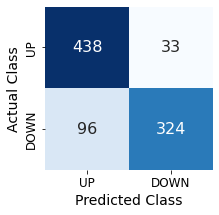

In [36]:
cm = confusion_matrix(y2_test, y_pred, labels = clf.classes_)
plot_confusion_mtx(cm, ['UP', 'DOWN'], binary = False)

The classifier has good performances though we built a full tree without tuning the hyperparameters. Now let's try to unbalance the WALKING DOWNSTAIRS class.

---

In [37]:
y2_train.value_counts()

2    1070
3     951
Name: 0, dtype: int64

In [38]:
'''
In order to obtain a 96-4% proportion we need 
to sample 44 WALKING_DOWNSTAIRS instances
'''

walk_down_idx = y2_train[y2_train == 3].index
walk_up_idx = y2_train[y2_train == 2].index
sampled_idx = generator.choice(walk_down_idx, 44, replace = False)
mask = np.sort(np.hstack((sampled_idx, walk_up_idx)))
X2_train_imb = X2_train.loc[mask]
y2_train_imb = y2_train.loc[mask]

X2_train_imb.shape, y2_train_imb.shape

((1114, 23), (1114,))

In [39]:
'''
relabel WALKING DOWNSTAIRS as 1 (positive class/minority class) 
and WALKING UPSTAIRS as 0 since the grid search raise a label error
'''

y2_train_imb = y2_train_imb.map(lambda x: 1 if x == 3 else 0)
y2_test = y2_test.map(lambda x: 1 if x == 3 else 0)

print(y2_train_imb.value_counts(), y2_test.value_counts(), sep = '\n')

0    1070
1      44
Name: 0, dtype: int64
0    471
1    420
Name: 0, dtype: int64


In [40]:
# imbalance, w/o tuning

dtc = DTC(random_state = 5).fit(X2_train_imb, y2_train_imb)
y2_pred_imb = dtc.predict(X2_test)

In [41]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [42]:
dtc.get_depth()

11

In [43]:
dtc.get_n_leaves()

18

In [44]:
print(classification_report(y2_test, y2_pred_imb))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       471
           1       0.88      0.71      0.79       420

    accuracy                           0.82       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.82      0.82       891



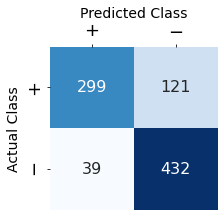

In [45]:
cm = confusion_matrix(y2_test, y2_pred_imb, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [46]:
# imbalance, w tuning

param = {'min_samples_leaf': list(range(5, 45, 5)),
         'max_leaf_nodes': list(range(5, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5, 
                           scoring = 'f1') # f1 is a good measure with class imbalance

In [47]:
grid_search.fit(X2_train_imb, y2_train_imb)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5),
             param_grid={'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                            50],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40]},
             scoring='f1')

In [48]:
# report(grid_search.cv_results_)

In [49]:
dtc_tuned = grid_search.best_estimator_
dtc_tuned

DecisionTreeClassifier(max_leaf_nodes=10, min_samples_leaf=5, random_state=5)

In [50]:
dtc_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [51]:
dtc_tuned.get_depth()

7

In [52]:
dtc_tuned.get_n_leaves()

10

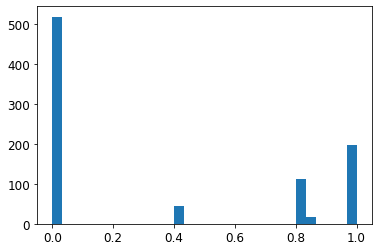

In [53]:
plt.hist(dtc_tuned.predict_proba(X2_test)[:, 1], bins = 30)
plt.show()

In [54]:
y2_pred_imb = dtc_tuned.predict(X2_test)

print(classification_report(y2_test, y2_pred_imb))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       471
           1       0.90      0.70      0.79       420

    accuracy                           0.82       891
   macro avg       0.84      0.82      0.82       891
weighted avg       0.84      0.82      0.82       891



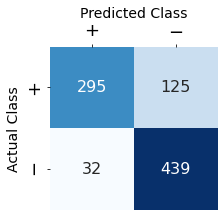

In [55]:
cm = confusion_matrix(y2_test, y2_pred_imb, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

As expected the classifier is biased toward the negative class. Let's try to use some imbalanced technique in order to enhance the performances.

#### Oversampling

##### Random Oversampling

In [56]:
ros = ROS(random_state = 5)
X2_ros_res, y2_ros_res = ros.fit_resample(X2_train_imb, y2_train_imb)

In [57]:
np.unique(y2_ros_res, return_counts = True)

(array([0, 1], dtype=int64), array([1070, 1070], dtype=int64))

In [58]:
# SMOTE, w/o tuning

dtc_rnd_over = DTC(random_state = 5).fit(X2_ros_res, y2_ros_res)

In [59]:
dtc_rnd_over.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [60]:
dtc_rnd_over.get_depth()

11

In [61]:
dtc_rnd_over.get_n_leaves()

15

In [62]:
y2_pred_res = dtc_rnd_over.predict(X2_test)

print(classification_report(y2_test, y2_pred_res))

              precision    recall  f1-score   support

           0       0.68      0.98      0.80       471
           1       0.96      0.47      0.63       420

    accuracy                           0.74       891
   macro avg       0.82      0.73      0.72       891
weighted avg       0.81      0.74      0.72       891



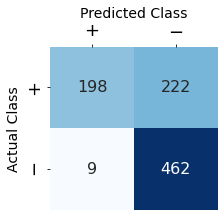

In [63]:
cm = confusion_matrix(y2_test, y2_pred_res, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [64]:
# oversampling, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10,41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [65]:
grid_search.fit(X2_ros_res, y2_ros_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [66]:
# report(grid_search.cv_results_)

In [67]:
dtc_rnd_over_tuned = grid_search.best_estimator_

In [68]:
dtc_rnd_over_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [69]:
dtc_rnd_over_tuned.get_depth()

3

In [70]:
dtc_rnd_over_tuned.get_n_leaves()

7

In [287]:
y2_ros_pred = dtc_rnd_over_tuned.predict(X2_test)

In [288]:
print(classification_report(y2_test, y2_ros_pred))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       471
           1       0.93      0.70      0.80       420

    accuracy                           0.83       891
   macro avg       0.86      0.83      0.83       891
weighted avg       0.85      0.83      0.83       891



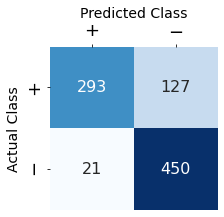

In [73]:
cm = confusion_matrix(y2_test, y2_ros_pred, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

##### SMOTE

In [74]:
y2_train_imb.value_counts()

0    1070
1      44
Name: 0, dtype: int64

Here, SMOTE for each record belonging to the minority class generates 1073/44 new artificial records. Each new record is produced by means of a linear combination with one randomly selected nearest neighbor.

In [75]:
smote = SMOTE(k_neighbors = 5, random_state = 5) 
X2_train_res, y2_train_res = smote.fit_resample(X2_train_imb, y2_train_imb)

In [76]:
X2_train_res.shape, y2_train_res.shape

((2140, 23), (2140,))

In [77]:
np.unique(y2_train_res, return_counts = True)

(array([0, 1], dtype=int64), array([1070, 1070], dtype=int64))

In [78]:
# SMOTE, w/o tuning

dtc_smote = DTC(random_state = 5).fit(X2_train_res, y2_train_res)

In [79]:
dtc_smote.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [80]:
dtc_smote.get_depth()

11

In [81]:
dtc_smote.get_n_leaves()

15

In [82]:
y2_pred_res = dtc_smote.predict(X2_test)

print(classification_report(y2_test, y2_pred_res))

              precision    recall  f1-score   support

           0       0.69      0.97      0.81       471
           1       0.94      0.52      0.67       420

    accuracy                           0.76       891
   macro avg       0.82      0.75      0.74       891
weighted avg       0.81      0.76      0.74       891



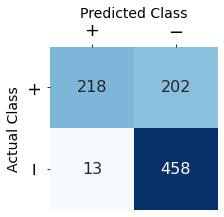

In [83]:
cm = confusion_matrix(y2_test, y2_pred_res, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

With respect to imbalanced classification, the SMOTE technique predicts more frequently positive and also reduces false negative predictions. False positive predictions increase moderately.

---

In [84]:
# SMOTE, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [85]:
grid_search.fit(X2_train_res, y2_train_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [86]:
# report(grid_search.cv_results_)

In [87]:
dtc_smote_tuned = grid_search.best_estimator_
dtc_smote_tuned

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10, min_samples_leaf=10,
                       random_state=5)

In [88]:
dtc_smote_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [89]:
dtc_smote_tuned.get_depth()

3

In [90]:
dtc_smote_tuned.get_n_leaves()

7

In [91]:
y2_pred_smote_tuned = dtc_smote_tuned.predict(X2_test)

print(classification_report(y2_test, y2_pred_res))

              precision    recall  f1-score   support

           0       0.69      0.97      0.81       471
           1       0.94      0.52      0.67       420

    accuracy                           0.76       891
   macro avg       0.82      0.75      0.74       891
weighted avg       0.81      0.76      0.74       891



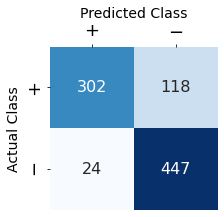

In [92]:
cm = confusion_matrix(y2_test, y2_pred_smote_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

The classifier after the tuning step improves significantly its performances on the negative class without make worsening the predictions of the positive one.

---

##### ADASYN

ADASYN is very similar to SMOTE the only difference is that instead to produce the same number of artificial records for each actual point of the minority class, the minority records that in their neighborhood have more objects belonging to the majority class (and thus are "harder-to-learn"), produce more artificial instances.

In [93]:
adasyn = ADASYN(random_state = 5, n_neighbors = 3, n_jobs = -1)
X2_adasyn_res, y2_adasyn_res = adasyn.fit_resample(X2_train_imb, y2_train_imb)

In [94]:
np.unique(y2_adasyn_res, return_counts = True)

(array([0, 1], dtype=int64), array([1070, 1073], dtype=int64))

In [95]:
# ADASYN, w/o tuning

dtc_adasyn = DTC(random_state = 5).fit(X2_adasyn_res, y2_adasyn_res)

In [96]:
dtc_adasyn.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [97]:
dtc_adasyn.get_depth()

11

In [98]:
dtc_adasyn.get_n_leaves()

17

In [99]:
y2_pred_adasyn = dtc_adasyn.predict(X2_test)
print(classification_report(y2_test, y2_pred_adasyn))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       471
           1       0.94      0.55      0.70       420

    accuracy                           0.77       891
   macro avg       0.83      0.76      0.76       891
weighted avg       0.82      0.77      0.76       891



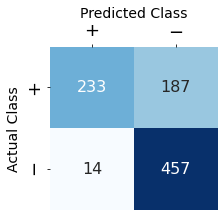

In [100]:
cm = confusion_matrix(y2_test, y2_pred_adasyn, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [101]:
# ADASYN, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [102]:
grid_search.fit(X2_adasyn_res, y2_adasyn_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [103]:
# report(grid_search.cv_results_)

In [104]:
dtc_adasyn_tuned = grid_search.best_estimator_
dtc_adasyn_tuned

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10, min_samples_leaf=10,
                       random_state=5)

In [105]:
dtc_adasyn_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [106]:
dtc_adasyn_tuned.get_depth()

3

In [107]:
dtc_adasyn_tuned.get_n_leaves()

7

In [108]:
y2_pred_adasyn_tuned = dtc_adasyn_tuned.predict(X2_test)

print(classification_report(y2_test, y2_pred_adasyn))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       471
           1       0.94      0.55      0.70       420

    accuracy                           0.77       891
   macro avg       0.83      0.76      0.76       891
weighted avg       0.82      0.77      0.76       891



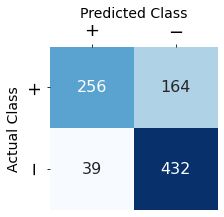

In [109]:
cm = confusion_matrix(y2_test, y2_pred_adasyn_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

In this imbalanced scenario, this algorithm obtained the best performaces.

#### Undersampling

##### Random undersampling

In [110]:
under = RUS(random_state = 5)
X2_under_res, y2_under_res = under.fit_resample(X2_train_imb, y2_train_imb)

In [111]:
np.unique(y2_under_res, return_counts = True)

(array([0, 1], dtype=int64), array([44, 44], dtype=int64))

The train set contains only 44 instances

In [112]:
# undersampling, w/o tuning

dtc_under = DTC(random_state = 5).fit(X2_under_res, y2_under_res)

In [113]:
dtc_under.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [114]:
dtc_under.get_depth()

4

In [115]:
dtc_under.get_n_leaves()

7

In [116]:
y2_pred_under = dtc_under.predict(X2_test)
print(classification_report(y2_test, y2_pred_under))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       471
           1       0.87      0.69      0.77       420

    accuracy                           0.80       891
   macro avg       0.82      0.80      0.80       891
weighted avg       0.81      0.80      0.80       891



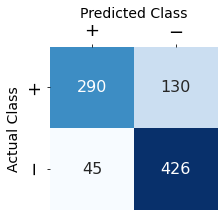

In [117]:
cm = confusion_matrix(y2_test, y2_pred_under, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [118]:
# undersampling, w tuning

param = {'min_samples_leaf': list(range(5, 25)),
         'max_leaf_nodes': list(range(4, 11))}


grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = LeaveOneOut(),
                           n_jobs = -1,
                           scoring = 'accuracy')

In [119]:
grid_search.fit(X2_under_res, y2_under_res)

GridSearchCV(cv=LeaveOneOut(), estimator=DecisionTreeClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'max_leaf_nodes': [4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                              15, 16, 17, 18, 19, 20, 21, 22,
                                              23, 24]},
             scoring='accuracy')

In [120]:
# report(grid_search.cv_results_)

In [121]:
dtc_under_tuned = grid_search.best_estimator_
dtc_under_tuned

DecisionTreeClassifier(max_leaf_nodes=4, min_samples_leaf=5, random_state=5)

In [122]:
dtc_under_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [123]:
dtc_under_tuned.get_depth()

2

In [124]:
dtc_under_tuned.get_n_leaves()

4

In [125]:
y2_pred_under_tuned = dtc_under_tuned.predict(X2_test)

print(classification_report(y2_test, y2_pred_under))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       471
           1       0.87      0.69      0.77       420

    accuracy                           0.80       891
   macro avg       0.82      0.80      0.80       891
weighted avg       0.81      0.80      0.80       891



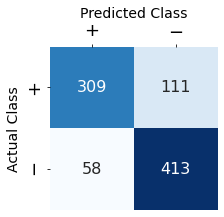

In [126]:
cm = confusion_matrix(y2_test, y2_pred_under_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

The random undersampling technique produces better results comparing to SMOTE, in spite of the vary small train set. This might depend on three factors: the test set is balanced; the undersampling technique does not produce artificial instances; WALKING DOWNSTAIRS and UPSTAIRS are well distinguish activities and the classifier does not need many instances to build a reliable model.

---

##### CNN

1. Get all minority samples in a set C.

2. Add a sample from the targeted class (class to be under-sampled) in C and all other samples of this class in a set S.

3. Go through the set S, sample by sample, and classify each sample using a 1 nearest neighbor rule.

4. If the sample is misclassified, add it to C, otherwise do nothing.

5. Reiterate on S until there is no samples to be added.

In [127]:
cnn = CNN(random_state = 5, n_jobs = -1)
X_cnn_res, y_cnn_res = cnn.fit_resample(X2_train_imb, y2_train_imb.values)

In [128]:
np.unique(y_cnn_res, return_counts = True)

(array([0, 1], dtype=int64), array([37, 44], dtype=int64))

The CNN does not always produce class with the same cardinality

In [129]:
# CNN, w/o tuning

dtc_cnn = DTC(random_state = 5).fit(X_cnn_res, y_cnn_res)

In [130]:
dtc_cnn.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [131]:
dtc_cnn.get_depth()

5

In [132]:
dtc_cnn.get_n_leaves()

8

In [133]:
y2_pred_cnn = dtc_cnn.predict(X2_test)

print(classification_report(y2_test, y2_pred_cnn))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       471
           1       0.87      0.74      0.80       420

    accuracy                           0.83       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.83      0.82       891



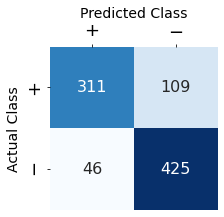

In [134]:
cm = confusion_matrix(y2_test, y2_pred_cnn, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [135]:
# CNN, w tuning

param = {'min_samples_leaf': list(range(5, 25)),
         'max_leaf_nodes': list(range(4,11))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = LeaveOneOut(),
                           n_jobs = -1,
                           scoring = 'accuracy')

In [136]:
grid_search.fit(X_cnn_res, y_cnn_res)

GridSearchCV(cv=LeaveOneOut(), estimator=DecisionTreeClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'max_leaf_nodes': [4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                              15, 16, 17, 18, 19, 20, 21, 22,
                                              23, 24]},
             scoring='accuracy')

In [137]:
# report(grid_search.cv_results_)

In [138]:
dtc_cnn_tuned = grid_search.best_estimator_
dtc_cnn_tuned

DecisionTreeClassifier(max_leaf_nodes=4, min_samples_leaf=17, random_state=5)

In [139]:
dtc_cnn_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [140]:
dtc_cnn_tuned.get_depth()

3

In [141]:
dtc_cnn_tuned.get_n_leaves()

4

In [142]:
y2_pred_cnn_tuned = dtc_cnn_tuned.predict(X2_test)

print(classification_report(y2_test, y2_pred_cnn))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       471
           1       0.87      0.74      0.80       420

    accuracy                           0.83       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.83      0.82       891



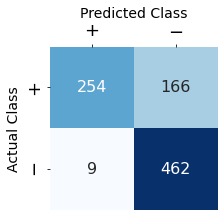

In [143]:
cm = confusion_matrix(y2_test, y2_pred_cnn_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

The bad performances of CNN with hyperparameter tuning might depend on the small cardinality of the training set. Indeed, the parameter ranges are not compatible with only 44 records. 

---

##### TomekLinks

TomekLinks performs an undersampling by removing the object belonging to majority class of each Tomek’s link. A Tomek’s link is when two records belong to different classes and they are both nearest neighbors of each others.

In [144]:
tomek = TomekLinks(n_jobs = -1)
X_tomek_res, y_tomek_res = tomek.fit_resample(X2_train_imb, y2_train_imb)

In [145]:
np.unique(y_tomek_res, return_counts = True)

(array([0, 1], dtype=int64), array([1070,   44], dtype=int64))

In [146]:
np.unique(y2_train_imb, return_counts = True)

(array([0, 1], dtype=int64), array([1070,   44], dtype=int64))

The method doesn't resample the data. This might mean that the 1-NN of each point is an object belonging to the same class. Let's check this conjecture:

In [147]:
# 1st nearest neighbor of each object

dist_mtx = squareform(pdist(X2_train_imb))
firstNN_idx = np.argsort(dist_mtx)[:, 1]

In [148]:
# let's compare the label of each object with the label of its 1-NN

mask = y2_train_imb.values == y2_train_imb.iloc[firstNN_idx].values
mask.sum()

1101

In [149]:
y2_train_imb.size

1114

In general, 1101 objects out of 1114 have as 1-NN an instance belonging to the same class, hence the above conjecture is not correct. Indeed, 13 records have as 1-NN an object of the opposite class. Let's check now the 1-NN for only the objects belonging to the positive class.

In [150]:
# 1st nearest neighbor of each object belonging to the minority clalss

positive_idx = np.where(y2_train_imb.values == 1)[0]
positive_firstNN_idx = np.argsort(dist_mtx)[positive_idx, 1]
y2_train_imb.iloc[positive_firstNN_idx].sum()

32

Therefore, on 44 positive objects 32 have the 1st NN belonging to the same class whereas 12 of them have a negative object as 1st NN.

 Despite belonging to different classes (1st condition), two objects,
 in order to form a Tomek link, must also be both nearest neighbors of 
 each others (2nd condition). Therefore, now we check the 1-NN 
 of the objects that satisfy the 1st condition.

In [151]:
# 1-NN indeces of records belonging to the opposite classe.

A = firstNN_idx[np.where(~mask)[0]]

In [152]:
# 1-NN of 1-NN

B = firstNN_idx[A]
A == B

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In conclusion, we can assert that this algorithm does not work here because the 2nd condition doesn't hold.

---

##### Edited Nearest Neighbours

This is another undersampling technique based upon the nearest neighbors approach. Namely, for each object belonging to the majority class it checks the $k$ specified neighbors and according to a decision rule mantains or removes that record. Specifically, there are two alternatives:
 1) if all $k$ neighbors belong to the same class mantain that record, otherwise remove it;\
 2) if more then 50% of the $k$ neighbors are of the same class mantain the record, otherwise remove it.
 
Here we opt for the 1st decision rule since it is more aggressive.

In [153]:
enn = ENN(n_neighbors = 10, n_jobs = -1) # kind_sel = 'all'
X2_enn_res, y2_enn_res = enn.fit_resample(X2_train_imb, y2_train_imb)

In [154]:
np.unique(y2_enn_res, return_counts = True)

(array([0, 1], dtype=int64), array([1052,   44], dtype=int64))

In [155]:
np.unique(y2_train_imb, return_counts = True)

(array([0, 1], dtype=int64), array([1070,   44], dtype=int64))

Even this method does not have benefits with this dataset. Selecting a number of neighbors equal to 5 it removes only 9 records, whereas with n_neighbors = 10 it remove 18 objects.

---

#### Combination of over- and under-sampling methods

SMOTE can generate noisy samples by interpolating new points between marginal outliers and inliers. This issue can be solved by cleaning the space resulting from over-sampling by means of Tomek’s link or Edited Nearest-Neighbours undersampling techniques.

##### SMOTETomek 

We can use SMOTE in combination with TomekLinks in order to obtain both oversampling and undersampling advantages. This algorithm first perform the SMOTE oversampling and then apply Tomeklinks undersampling that clean the data by removing for each Tomek link both the objects (default sampling strategy = 'all').

In [156]:
smote_tomek = SMOTETomek(random_state = 5, n_jobs = -1)
X_smote_tomek_res, y_smote_tomek_res = smote_tomek.fit_resample(X2_train_imb, y2_train_imb)

In [157]:
np.unique(y_smote_tomek_res, return_counts = True)

(array([0, 1], dtype=int64), array([1070, 1070], dtype=int64))

As for the TomekLinks, the SMOTETomek does not find any Tomek link after the SMOTE step. Therefore, it produces the same results of the plain SMOTE.

##### SMOTEENN

First performs SMOTE and then Edited Nearest Neighbours.

In [158]:
enn = ENN(sampling_strategy = 'all', n_neighbors = 5, n_jobs = -1)
smoteenn = SMOTEENN(sampling_strategy = 'all', enn = enn, 
                    random_state = 5, n_jobs = -1)
X_smoteenn_res, y_smote_smoteenn_res = smoteenn.fit_resample(X2_train_imb, y2_train_imb)

In [159]:
np.unique(y_smote_smoteenn_res, return_counts = True)

(array([0, 1], dtype=int64), array([1051, 1070], dtype=int64))

In [160]:
# CNN, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [161]:
grid_search.fit(X_smoteenn_res, y_smote_smoteenn_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [162]:
# report(grid_search.cv_results_)

In [163]:
dtc_smoteen_tuned = grid_search.best_estimator_
dtc_smoteen_tuned

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10, min_samples_leaf=10,
                       random_state=5)

In [164]:
dtc_smoteen_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [165]:
dtc_smoteen_tuned.get_depth()

4

In [166]:
dtc_smoteen_tuned.get_n_leaves()

8

In [167]:
y2_smoteenn_pred = grid_search.predict(X2_test)

In [168]:
print(classification_report(y2_test, y2_smoteenn_pred))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83       471
           1       0.93      0.62      0.74       420

    accuracy                           0.80       891
   macro avg       0.83      0.79      0.79       891
weighted avg       0.83      0.80      0.79       891



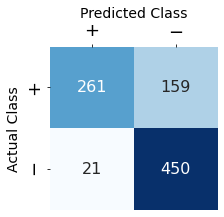

In [169]:
cm = confusion_matrix(y2_test, y2_smoteenn_pred, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

Results are better than to the plain SMOTE. However, the results of the two methods are note completely comparable since smoteen does not perform the same smote of the plain smote because of randomness.

Observation: we already saw that the 1st-NN of each object is 99% of times an object belonging to the same class. Since all the tested undersampling techniques based upon the NN perform bad (they remove almost all the records in CNN, whereas they does not remove anything in TomekLinks and ENN) this might mean that even the 2nd, 3th etc. NN of each object belong to the same class. In this scenario, the KNN classifier should have very good results.

---

#### Meta-Cost Sensitive Classifier

We are interested in predicting the positive class thus we have to put more weight on false negative predictions. However, if we put weight only on the FN predictions, the classifier predicts always the positive class. Therefore we need to penalize also the FP

In [170]:
fp, fn, tp, tn = 1, 10, 0, 0
cost_mtx = [fp, fn, tp, tn] * y2_train_imb.size
cost_mtx = np.array(cost_mtx).reshape(-1, 4)

In [171]:
cost_mtx

array([[ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       ...,
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0]])

In [172]:
X2_train_imb.shape, cost_mtx.shape

((1114, 23), (1114, 4))

In [173]:
'''
I don't know whether this algorithm can be tuned with GridSearchCV, but
even if it was, it is very inefficient and it would take too much time. 
Therfore, I pass the optimal hyperparameters tuned for the DTC.
'''

csdtc = CSDTC()
csdtc.fit(X2_train_imb.values, y2_train_imb.values, cost_mtx)

CostSensitiveDecisionTreeClassifier()

In [174]:
y2_pred_costmtx = csdtc.predict(X2_test.values)

In [175]:
print(classification_report(y2_test, y2_pred_costmtx))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84       471
           1       0.99      0.58      0.73       420

    accuracy                           0.80       891
   macro avg       0.86      0.79      0.79       891
weighted avg       0.85      0.80      0.79       891



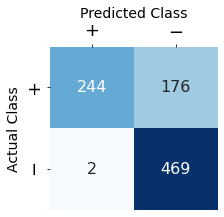

In [176]:
cm = confusion_matrix(y2_test, y2_pred_costmtx, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)
# plt.savefig('meta_cost_1,5,-1,0.pdf', format = 'pdf')

In [177]:
# Savings of using y_pred on y_true with cost-matrix cost-mat.
# The best performance is 1.

cost_mtx_test = cost_mtx[: X2_test.shape[0]]
savings_score(y2_test, y2_pred_costmtx, cost_mtx_test)

-2.740976645435244

In [178]:
# y2_pred_imb are the predicted classes of the pure and not tuning DTC

savings_score(y2_test, y2_pred_imb, cost_mtx_test)

-1.721868365180467

---

Observation: by looking at the accelerometer graph it is evident that the WALKING DOWNSTAIRS activity is characterized by a higher variance than WALKING UPSTAIRS. This can be shown from the two histograms below obtained by selecting a subgroup of features that measure the standard deviation of the acceleration signal. Therefore, based on the mean of these features, we can assign a cost to each record based on its mean with respect to these variables: higher is the mean, higher is the cost attributed to FN predictions.

In [179]:
# columns that measure variance

var_col = [3,83,201,214,227,268,347,503,516]

In [180]:
for col in var_col:
    print(features[col])

tBodyAcc-std()-X
tBodyAccJerk-std()-X
tBodyAccMag-std()
tGravityAccMag-std()
tBodyAccJerkMag-std()
fBodyAcc-std()-X
fBodyAccJerk-std()-X
fBodyAccMag-std()
fBodyBodyAccJerkMag-std()


In [181]:
# However, we are using the reduced dataset, thus we cannot
# consider all the attributes of the original dataset.

var_features = []
for col in var_col:
    if col in set(X2_train_imb.columns):
        var_features.append(col)

In [182]:
var_features

[503]

In [183]:
df2 = X2_train_imb.loc[:, var_features]
df2['target'] = y2_train_imb.values

In [184]:
df2.groupby('target').mean()

,503
target,
0,-0.349619
1,-0.082708


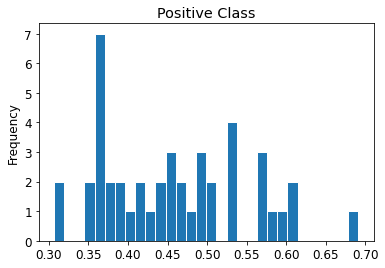

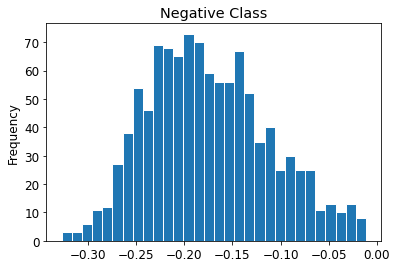

In [185]:
df2.loc[df2['target']==1].mean(axis = 1).plot.hist(bins = 30, edgecolor = 'w')
plt.title('Positive Class')
plt.show()

df2.loc[df2['target']==0].mean(axis = 1).plot.hist(bins = 30, edgecolor = 'w')
plt.title('Negative Class')
plt.show()

In [186]:
mask = df2.mean(axis = 1) > 0
weight_idx = set(X2_train_imb[mask].index)

In [187]:
cost_mtx = [] 
for idx in X2_train_imb.index:
    if idx in weight_idx:
        cost_mtx.append([1, 10, 0, 0])
    else:
        cost_mtx.append([10, 1, 0, 0])
        
cost_mtx = np.array(cost_mtx)

In [188]:
cost_mtx.shape

(1114, 4)

In [189]:
# for row in cost_mtx:
#     print(row)

In [190]:
csdtc_custom = CSDTC()
csdtc_custom.fit(X2_train_imb.values, y2_train_imb.values, cost_mtx)
y2_pred_costmtx_custom = csdtc_custom.predict(X2_test.values)

In [191]:
print(classification_report(y2_test, y2_pred_costmtx_custom))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       471
           1       1.00      0.36      0.53       420

    accuracy                           0.70       891
   macro avg       0.82      0.68      0.65       891
weighted avg       0.81      0.70      0.66       891



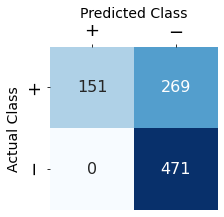

In [192]:
cm = confusion_matrix(y2_test, y2_pred_costmtx_custom, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

#### Class Weight 

In [193]:
''' 
class_weight="balanced" implicitly replicates the smaller class until 
it reaches the cardinality of the larger one.
'''

dtc_cw = DTC(class_weight = 'balanced', random_state = 5)
dtc_cw.fit(X2_train_imb.values, y2_train_imb.values)

DecisionTreeClassifier(class_weight='balanced', random_state=5)

In [194]:
dtc_cw.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [195]:
dtc_cw.get_depth()

12

In [196]:
dtc_cw.get_n_leaves()

16

In [197]:
y2_pred_cw = dtc_cw.predict(X2_test.values)

In [198]:
print(classification_report(y2_test, y2_pred_cw))

              precision    recall  f1-score   support

           0       0.68      0.98      0.80       471
           1       0.95      0.49      0.65       420

    accuracy                           0.75       891
   macro avg       0.82      0.73      0.73       891
weighted avg       0.81      0.75      0.73       891



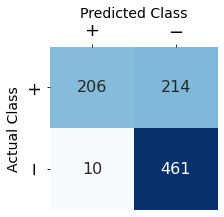

In [199]:
cm = confusion_matrix(y2_test, y2_pred_cw, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [200]:
np.unique(y2_train_imb, return_counts = True)

(array([0, 1], dtype=int64), array([1070,   44], dtype=int64))

We need the zero_devision parameter because of a warning raise for the following reason: [1]

When true positive + false positive == 0, precision is undefined. When true positive + false negative == 0, recall is undefined. In such cases, by default the metric will be set to 0, as will f-score, and UndefinedMetricWarning will be raised. This behavior can be modified with zero_division.

[1] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn-metrics-f1-score

In [201]:
f1 = make_scorer(f1_score , zero_division = 1)

In [202]:
# Class Weight, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(class_weight = 'balanced', random_state = 5), 
                           param_grid = param, cv = 5, 
                           scoring = f1)

In [203]:
grid_search.fit(X2_train_imb, y2_train_imb)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=5),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring=make_scorer(f1_score, zero_division=1))

In [204]:
dtc_cw_tuned = grid_search.best_estimator_
dtc_cw_tuned

DecisionTreeClassifier(class_weight='balanced', max_depth=3, max_leaf_nodes=10,
                       min_samples_leaf=10, random_state=5)

In [205]:
# report(grid_search.cv_results_)

In [206]:
dtc_cw_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [207]:
dtc_cw_tuned.get_depth()

3

In [208]:
dtc_cw_tuned.get_n_leaves()

6

In [209]:
y2_pred_cw_tuned = dtc_cw_tuned.predict(X2_test)
print(classification_report(y2_test, y2_pred_cw_tuned))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       471
           1       0.93      0.78      0.85       420

    accuracy                           0.87       891
   macro avg       0.88      0.86      0.87       891
weighted avg       0.88      0.87      0.87       891



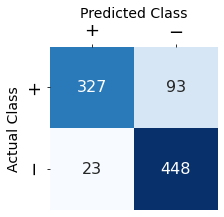

In [210]:
cm = confusion_matrix(y2_test, y2_pred_cw_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

#### Comparison among imbalanced techniques

For comparisons let's consider only tuned classifiers

In [276]:
classifiers = [dtc_tuned, dtc_under_tuned, dtc_cnn_tuned, 
               dtc_rnd_over_tuned, dtc_smote_tuned, 
               dtc_adasyn_tuned, dtc_cw_tuned]
labels = ['No imb. technique', 'Rnd Undersampling', 'CNN', 
          'Rnd Oversampling', 'SMOTE', 'ADASYN', 'CostWeight']

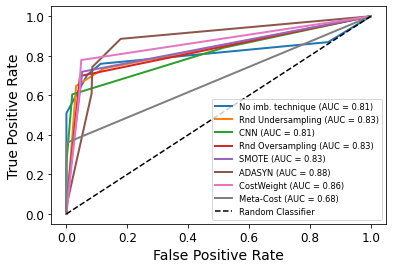

In [313]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
for i, cls in enumerate(classifiers):
    roc = RocCurveDisplay.from_estimator(cls, X2_test, y2_test, ax = ax,
                                         name = labels[i], lw = 2)
RocCurveDisplay.from_predictions(y2_test, y2_pred_costmtx_custom, ax = ax,
                                    lw = 2, name = 'Meta-Cost')
random = ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--', 
                 label = 'Random Classifier')
ax.legend(fontsize = 'x-small')
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_xlabel('False Positive Rate', fontsize = 14)
# plt.savefig('imb_roc_comparison.pdf', bbox_inches = 'tight')
plt.show()

Except the meta-cost sensitive classifier, all the others perform very similarly to the model that does not use any imbalanced techniques. 

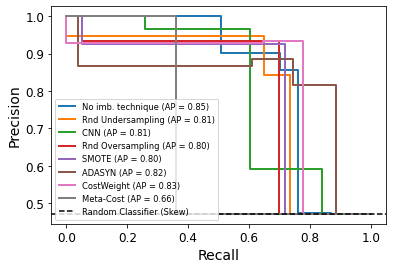

In [312]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
for i, cls in enumerate(classifiers):
    roc = PrecisionRecallDisplay.from_estimator(cls, X2_test, y2_test, ax = ax, 
                                        name = labels[i], lw = 2)
PrecisionRecallDisplay.from_predictions(y2_test, y2_pred_costmtx_custom, 
                                        ax = ax, lw = 2, name = 'Meta-Cost')    
random = ax.axhline(y = (y2_test.sum() / y2_test.size), ls = '--', 
                    color = 'k', label = 'Random Classifier (Skew)')
ax.legend(fontsize = 'x-small')
ax.set_ylabel('Precision', fontsize = 14)
ax.set_xlabel('Recall', fontsize = 14)
# plt.savefig('imb_pre_rec_comparison.pdf', bbox_inches = 'tight')
plt.show()

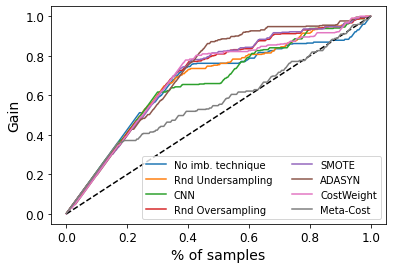

In [311]:
plt.figure(figsize = (6, 4))
n = len(classifiers)
for i, cls in enumerate(classifiers):
    pred = cls.predict_proba(X2_test.values)[:,1]
    plot_gains_curve(y2_test.values, pred, labels[i], baseline = i == n-1)
pred = csdtc_custom.predict_proba(X2_test.values)[:,1]
plot_gains_curve(y2_test.values, pred, 'Meta-Cost')
plt.legend(loc = 'lower right', fontsize = 'small', ncol = 2)
# plt.savefig('imb_gain_comparison.pdf', bbox_inches = 'tight')
plt.show()

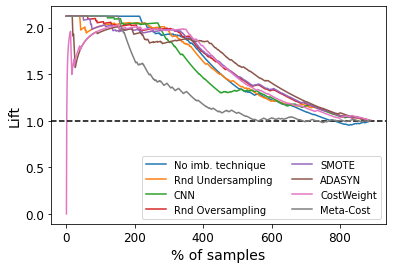

In [310]:
plt.figure(figsize = (6, 4))
for i, cls in enumerate(classifiers):
    pred = cls.predict_proba(X2_test.values)[:,1]
    plot_lift(y2_test.values, pred, labels[i], baseline = i == n-1)
pred = csdtc_custom.predict_proba(X2_test.values)[:,1]
plot_lift(y2_test.values, pred, 'Meta-Cost')
plt.legend(loc = 'lower right', fontsize = 'small', ncol = 2)
# plt.savefig('imb_lift_comparison.pdf', bbox_inches = 'tight')
plt.show()

In [305]:
imb_techniques = {
              'Unbalanced' : [82, 79, 90, 70],
              'Rnd Over' : [83, 80, 93, 70],
              'SMOTE' : [76, 67, 94, 52],
              'ADASYN' : [77, 70, 94, 55],
              'Rnd Under' : [80, 77, 87, 69],
              'CNN' : [83, 80, 87, 74],
              'TomekLinks' : [82, 79, 90, 70],
              'ENN' : [82, 79, 90, 70],
              'SMOTETomek' : [76, 67, 94, 52],
              'SMOTEENN' : [80, 74, 93, 62],
              'Meta Cost' : [80, 73, 99, 58],
              'Class Weight' : [87, 85, 93, 78]
              }
score_idx = ['Accuracy', 'F1', 'Precision', 'Recall']
df_imb_tech = pd.DataFrame(imb_techniques, index = score_idx)

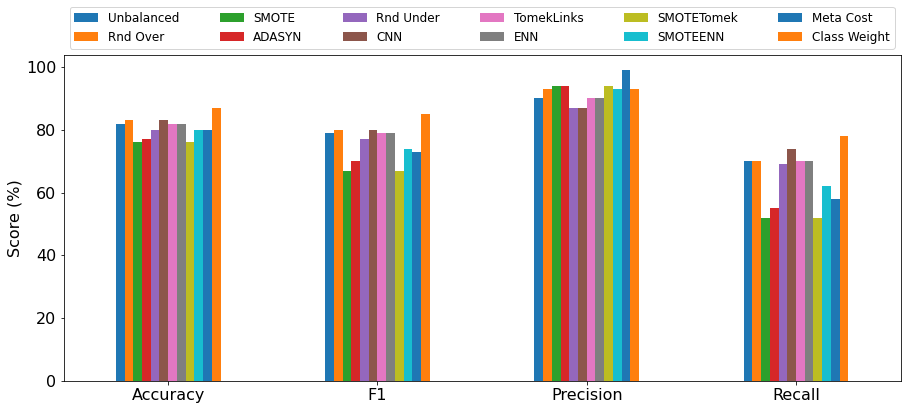

In [309]:
fig, ax = plt.subplots(figsize = (15,6))
df_imb_tech.plot.bar(ax = ax, rot = 0, fontsize = 16)
ax.legend(loc = 'lower center', ncol = 6, fontsize = 12, 
              bbox_to_anchor = (0, 1, 1, 1), mode = 'expand')
ax.set_ylabel('Score (%)', fontsize = 16)
# plt.savefig('imb_score_comparison.pdf', bbox_inches = 'tight')
plt.show()

---

### 3)

In [216]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [217]:
y_train.value_counts()

6    1378
5    1373
4    1277
1    1225
2    1070
3     951
Name: 0, dtype: int64

Let's unbalance the WALKING DOWNSTAIRS and perform a multiclass classification.

In [218]:
# let's extract only 50 records of the WALKING DOWNSTAIRS class

mask = y_train == 3
walk_down_idx = y_train[mask].index
residual_idx = y_train[~mask].index
samp_idx = generator.choice(walk_down_idx, 50, replace = False)
final_idx = np.sort(np.hstack((residual_idx, samp_idx)))
X3_train_res, y3_train_res = X_train.loc[final_idx], y_train.loc[final_idx]

In [219]:
X3_train_res.shape, y3_train_res.shape

((6373, 23), (6373,))

In [220]:
y3_train_res.value_counts()

6    1378
5    1373
4    1277
1    1225
2    1070
3      50
Name: 0, dtype: int64

In [221]:
# imbalance, w/o tuning

clf = DTC(random_state = 5).fit(X3_train_res, y3_train_res)

In [222]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [223]:
clf.get_depth()

16

In [224]:
clf.get_n_leaves()

147

In [225]:
y3_pred = clf.predict(X_test)

In [226]:
print(classification_report(y_test, y3_pred, 
                            target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.77      0.96      0.85       496
  WALKING_UPSTAIRS       0.75      0.87      0.81       471
WALKING_DOWNSTAIRS       0.97      0.51      0.67       420
           SITTING       0.82      0.75      0.78       491
          STANDING       0.78      0.84      0.81       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.83      2947
         macro avg       0.85      0.82      0.82      2947
      weighted avg       0.85      0.83      0.83      2947



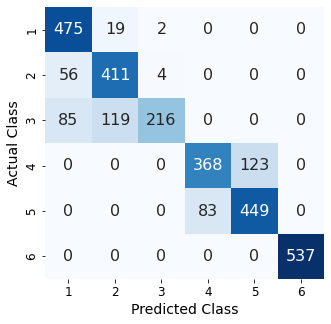

In [227]:
cm = confusion_matrix(y_test, y3_pred, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

---

For multiclass classification we cannot use the f1 score

https://stats.stackexchange.com/questions/431022/error-while-performing-multiclass-classification-using-gridsearch-cv

In [228]:
# imbalance, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'f1_weighted')

In [229]:
grid_search.fit(X3_train_res, y3_train_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='f1_weighted')

In [230]:
# report(grid_search.cv_results_)

In [231]:
dtc_multi = grid_search.best_estimator_

In [232]:
dtc_multi.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': 30,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [233]:
dtc_multi.get_depth()

8

In [234]:
dtc_multi.get_n_leaves()

30

In [235]:
y3_pred = grid_search.predict(X_test)

In [236]:
print(classification_report(y_test, y3_pred, 
                            target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.80      0.94      0.87       496
  WALKING_UPSTAIRS       0.69      0.91      0.78       471
WALKING_DOWNSTAIRS       0.94      0.40      0.57       420
           SITTING       0.88      0.73      0.80       491
          STANDING       0.78      0.91      0.84       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.83      2947
         macro avg       0.85      0.82      0.81      2947
      weighted avg       0.85      0.83      0.82      2947



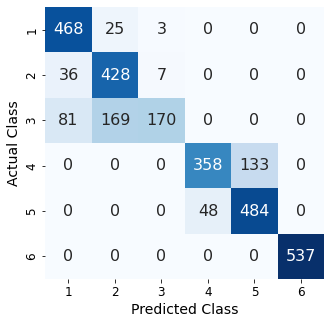

In [237]:
cm = confusion_matrix(y_test, y3_pred, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

The classifier does not predict WALKING DOWN very often but when it does it hits the nail on the head (high precision). On the other hand, it fails to distinguish it when it actually occurs, incorrectly predicting it as one of the other two movement activities (very poor recall).

---

Let's try some imbalance techniques.

##### ADASYN

In [238]:
# we only preform the oversamplig of the minority class

adasyn = ADASYN(random_state = 5, n_neighbors = 3, 
                sampling_strategy = 'minority', n_jobs = -1)
X3_adasyn_res, y3_adasyn_res = adasyn.fit_resample(X3_train_res, y3_train_res)

In [239]:
np.unique(y3_adasyn_res, return_counts = True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([1225, 1070, 1373, 1277, 1373, 1378], dtype=int64))

In [240]:
# ADASYN, w/o tuning

dtc_adasyn_multi = DTC(random_state = 5).fit(X3_adasyn_res, y3_adasyn_res)

In [241]:
dtc_adasyn_multi.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [242]:
dtc_adasyn_multi.get_depth()

20

In [243]:
dtc_adasyn_multi.get_n_leaves()

162

In [244]:
y3_pred_adasyn = dtc_adasyn_multi.predict(X_test)

print(classification_report(y_test, y3_pred_adasyn,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.76      0.97      0.85       496
  WALKING_UPSTAIRS       0.68      0.84      0.75       471
WALKING_DOWNSTAIRS       0.95      0.38      0.54       420
           SITTING       0.82      0.75      0.78       491
          STANDING       0.78      0.84      0.81       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.81      2947
         macro avg       0.83      0.80      0.79      2947
      weighted avg       0.83      0.81      0.80      2947



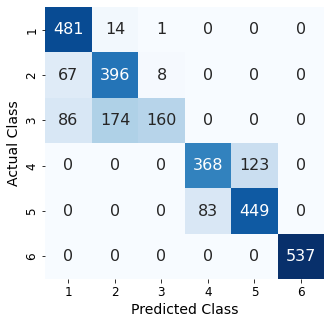

In [245]:
cm = confusion_matrix(y_test, y3_pred_adasyn, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

---

In [246]:
# ADASYN, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [247]:
grid_search.fit(X3_adasyn_res, y3_adasyn_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [248]:
dtc_adasyn_multi_tuned = grid_search.best_estimator_
dtc_adasyn_multi_tuned

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=25, min_samples_leaf=20,
                       random_state=5)

In [249]:
dtc_adasyn_multi_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': 25,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [250]:
dtc_adasyn_multi_tuned.get_depth()

7

In [251]:
dtc_adasyn_multi_tuned.get_n_leaves()

25

In [252]:
y3_adasyn_pred = dtc_adasyn_multi_tuned.predict(X_test)
print(classification_report(y_test, y3_adasyn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.78      0.93      0.84       496
  WALKING_UPSTAIRS       0.67      0.85      0.75       471
WALKING_DOWNSTAIRS       0.92      0.44      0.60       420
           SITTING       0.90      0.68      0.77       491
          STANDING       0.76      0.93      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.82      2947
         macro avg       0.84      0.80      0.80      2947
      weighted avg       0.84      0.82      0.81      2947



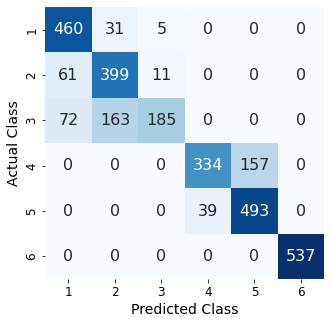

In [253]:
cm = confusion_matrix(y_test, y3_adasyn_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)

##### CNN

In [254]:
cnn = CNN(random_state = 5, n_jobs = -1)
X3_cnn_res, y3_cnn_res = cnn.fit_resample(X3_train_res, y3_train_res)

In [255]:
y3_cnn_res.value_counts()

3    50
2    34
1    27
4     6
5     5
6     4
Name: 0, dtype: int64

In [256]:
dtc_multi_cnn = DTC(random_state = 5).fit(X3_cnn_res, y3_cnn_res)

In [257]:
dtc_multi_cnn.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [258]:
dtc_multi_cnn.get_depth()

7

In [259]:
dtc_multi_cnn.get_n_leaves()

21

In [260]:
y3_cnn_pred = dtc_multi_cnn.predict(X_test)

print(classification_report(y_test, y3_cnn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.53      0.76      0.62       496
  WALKING_UPSTAIRS       0.71      0.74      0.73       471
WALKING_DOWNSTAIRS       0.92      0.73      0.81       420
           SITTING       0.76      0.63      0.69       491
          STANDING       0.71      0.73      0.72       532
            LAYING       0.95      0.79      0.86       537

          accuracy                           0.73      2947
         macro avg       0.76      0.73      0.74      2947
      weighted avg       0.76      0.73      0.74      2947



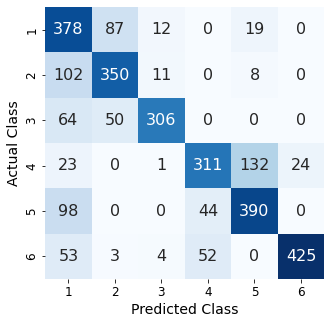

In [261]:
cm = confusion_matrix(y_test, y3_cnn_pred, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

---

The CNN selects only very few records for the movement classes. For this reason, it is not possible to tune the parameters (an error is raised).

In [466]:
# CNN w tuning

param = {'min_samples_leaf': list(range(1, 25)),
         'max_leaf_nodes': list(range(1,11))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = LeaveOneOut(),
                           n_jobs = -1,
                           scoring = 'f1_weighted')

In [467]:
grid_search.fit(X3_cnn_res, y3_cnn_res)

C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3024 fits failed out of a total of 30240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3024 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\tree\_classes.py", line 314, in fit
    raise ValueError(
ValueError: max_leaf_nodes 1 m

GridSearchCV(cv=LeaveOneOut(), estimator=DecisionTreeClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24]},
             scoring='f1_weighted')

In [468]:
y3_cnn_pred = grid_search.predict(X_test)

print(classification_report(y_test, y3_cnn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.48      0.76      0.59       496
  WALKING_UPSTAIRS       0.69      0.64      0.66       471
WALKING_DOWNSTAIRS       0.94      0.72      0.81       420
           SITTING       0.39      0.68      0.50       491
          STANDING       0.71      0.73      0.72       532
            LAYING       0.00      0.00      0.00       537

          accuracy                           0.58      2947
         macro avg       0.53      0.59      0.55      2947
      weighted avg       0.52      0.58      0.53      2947



C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


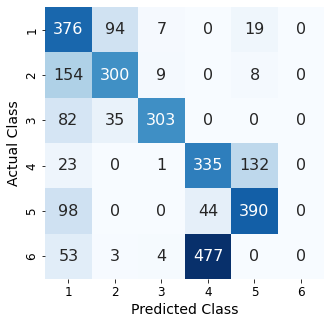

In [469]:
cm = confusion_matrix(y_test, y3_cnn_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)

---

##### Random undersampling

In [262]:
under = RUS(sampling_strategy = 'not minority', random_state = 5)
X3_under_res, y3_under_res = under.fit_resample(X3_train_res, y3_train_res)

In [263]:
y3_under_res.value_counts()

1    50
2    50
3    50
4    50
5    50
6    50
Name: 0, dtype: int64

In [264]:
# CNN, w tuning

param = {'max_depth': list(range(3,11)),
         'min_samples_leaf': list(range(10, 41, 5)),
         'max_leaf_nodes': list(range(5, 31, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [265]:
grid_search.fit(X3_under_res, y3_under_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [10, 15, 20, 25, 30, 35, 40]},
             scoring='accuracy')

In [266]:
dtc_multi_und = grid_search.best_estimator_

In [267]:
dtc_multi_und.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 35,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

In [268]:
dtc_multi_und.get_depth()

4

In [269]:
dtc_multi_und.get_n_leaves()

6

In [270]:
y3_under_pred = dtc_multi_und.predict(X_test)

print(classification_report(y_test, y3_under_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.84      0.75      0.79       496
  WALKING_UPSTAIRS       0.70      0.91      0.79       471
WALKING_DOWNSTAIRS       0.91      0.73      0.81       420
           SITTING       0.79      0.81      0.80       491
          STANDING       0.82      0.80      0.81       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.84      2947
         macro avg       0.84      0.83      0.83      2947
      weighted avg       0.84      0.84      0.84      2947



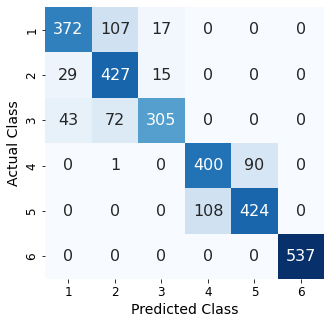

In [271]:
cm = confusion_matrix(y_test, y3_under_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)